In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter,filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap
from multiprocessing.pool import ThreadPool
from sklearn.naive_bayes import GaussianNB
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from contextlib import suppress
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import shuffle
import seaborn as sns
from time import time
import pandas as pd
import numpy as np
import scipy.io
import pickle
import glob
import sys
import gc
import os
import re
filterwarnings('ignore')
filterwarnings(action='once')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
simplefilter('ignore', FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [3]:
code_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Codes/Shared Codes'
data_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data'
results_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results"
image_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Images"
csv_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/CSV"

folders_evolving = ["kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest",
                    "kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS",
                    "kpfaoselm_gp_combiner_with_model_replacement_evolving",
                    "kpfaoselm_gp_combiner_with_model_replacement_evolving_IssamDFS",
                    ]
folders_without_evolving = ["kpfaoselm_gp_combiner_with_model_replacement_random_forest",
                            "kpfaoselm_gp_combiner_with_model_replacement_DFS",
                            "kpfaoselm_gp_combiner_with_model_replacement",
                            "kpfaoselm_gp_combiner_with_model_replacement_IssamDFS",
                            ]
sys.path.insert(0,code_path)
from ensemble import Ensemble, Classifier

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [4]:
# 'Recurrent_Drift.csv', 'Blip_Drift.csv', 'Incremental_Drift.csv', 'Gradual_Drift.csv','Sudden_Drift.csv'
filenames = ['ISCX2012.csv', 'CSE-CIC2018.csv', 'CICIDS2017.csv', 'kddcup99_csv.csv']
files = list(map(lambda x: os.path.join(data_path, x), filenames))
print("Data Names : ",filenames)
print("Paths : ",files)

Data Names :  ['ISCX2012.csv', 'CSE-CIC2018.csv', 'CICIDS2017.csv', 'kddcup99_csv.csv']
Paths :  ['/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/ISCX2012.csv', '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/CSE-CIC2018.csv', '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/CICIDS2017.csv', '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/kddcup99_csv.csv']


In [5]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object
def save_pickle(obj, file_name):
  with open(file_name, 'wb') as f:
    pickle.dump(obj, f)
def load_pickle(file_name):
  with open(file_name, 'rb') as f:
    d = pickle.load(f)
  return d

In [13]:
def plot_results(metric_name, methods_name, results, colors, data_name,drift_location=None, Name="", step=1):
    plt.figure(figsize=(25, 8))
    plt.title(data_name+" "+Name)
    for k, result in enumerate(results):
        x = [i for i, x in enumerate(results[k]) if i % step == 0]
        y = [x for i, x in enumerate(results[k]) if i % step == 0]
        plt.plot(x, y, color=colors[k], label=methods_name[k])
        plt.scatter(x, y, color=colors[k], s=20)
        if not drift_location is None:
          for loc in drift_location[k]:
            if type(loc) is str : continue
            loc = loc-1
            y_value = y[loc]
            plt.plot(loc, y_value, marker="o", markersize=9, markerfacecolor=colors[k])
    plt.legend(loc="best")
    plt.xlabel('Chunk number')
    plt.ylabel(metric_name)
    ax = plt.gca()
    ax.locator_params(axis='y', nbins=15)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))
    num_ticks = 50
    ax.xaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax.xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False, useMathText=True))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(rotation=45, fontsize='xx-small')
    plt.grid()
    my_path = os.path.join(image_path,"{}".format(data_name))
    os.makedirs(my_path, exist_ok=True)
    plt.savefig(os.path.join(my_path, metric_name+"_"+Name))
    plt.savefig(os.path.join(my_path, metric_name+"_"+Name+'.svg'), format='svg')
    plt.show()

In [14]:
def Finall_Results(folders,Name=""):
  # ,'Recurrent', 'Blip', 'Incremental', 'GradualDrift', 'SuddenDrift'
  data_names = ['ISCX2012', 'CSE-CIC2018', 'CICIDS2017', 'KddCup99'] #

  method_names = ["GPC-OS RandomForest", # RandomForest feature selection
                  "GPC-OS DFS", # our method
                  "GPC-OS",  # without any feature selection
                  "GPC-OS Isaam DFS" # Issam's method feature selection
                  ]

  metrices = ["accuracy", "precision", "recall", "f1-score", "auc", "Prediction Times", "Selected Feature"]



  colors = ['g', 'r', 'b','orange']
  data_folders = list(map(lambda x: os.path.join(image_path, x), data_names))
  for i, data_folder in enumerate(data_folders):
    for j, metrice in enumerate(metrices):
      csv_path = os.path.join(data_folder, metrice+"_"+Name)
      df = pd.read_csv(csv_path+".csv")
      results = []
      drift_location = []
      for k, method_name in enumerate(method_names):
        results.append(df[method_name].tolist())
        drift_location.append(list(load_object(filenames[i]+"_drift_location",os.path.join(os.path.join(results_path,folders[k]),filenames[i])).keys()))
      plot_results(metrice, method_names, results, colors, data_names[i], drift_location, Name, step=1)

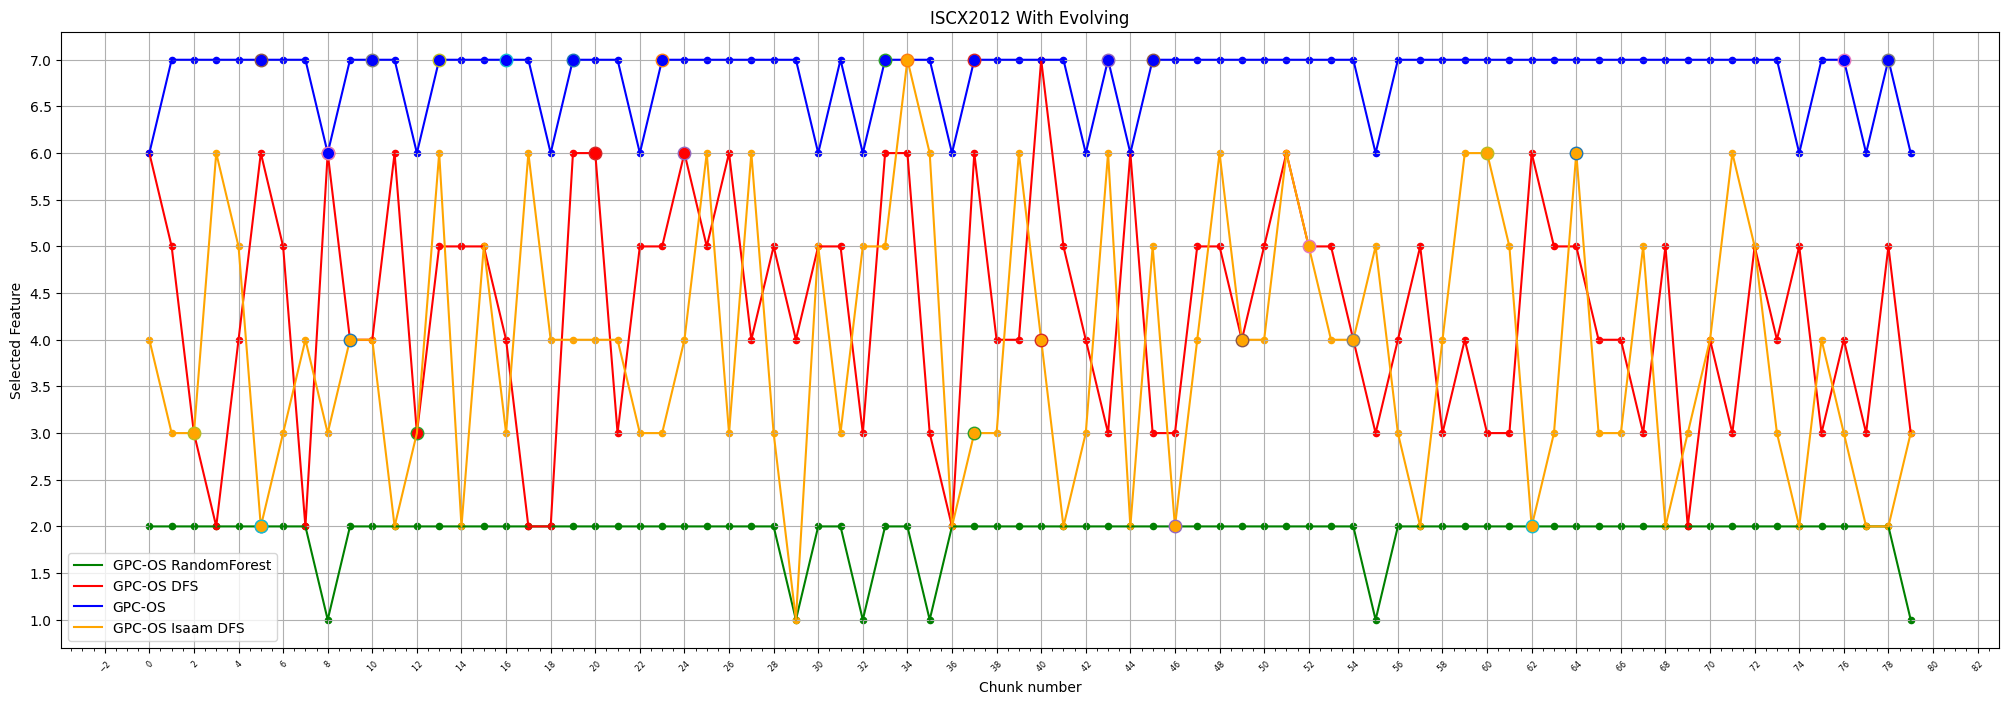

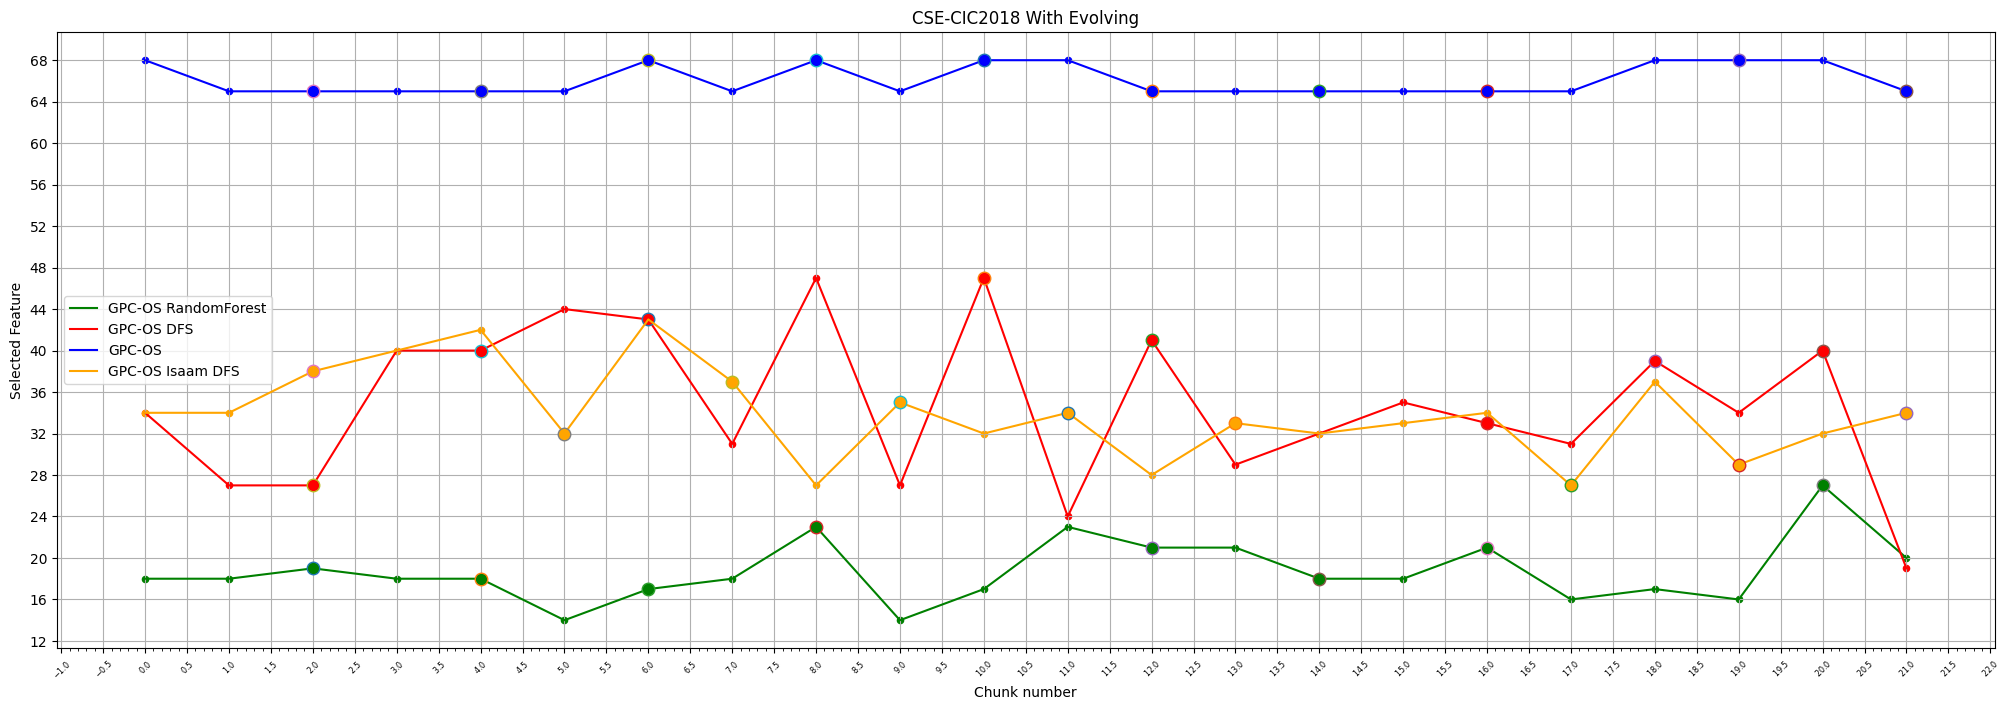

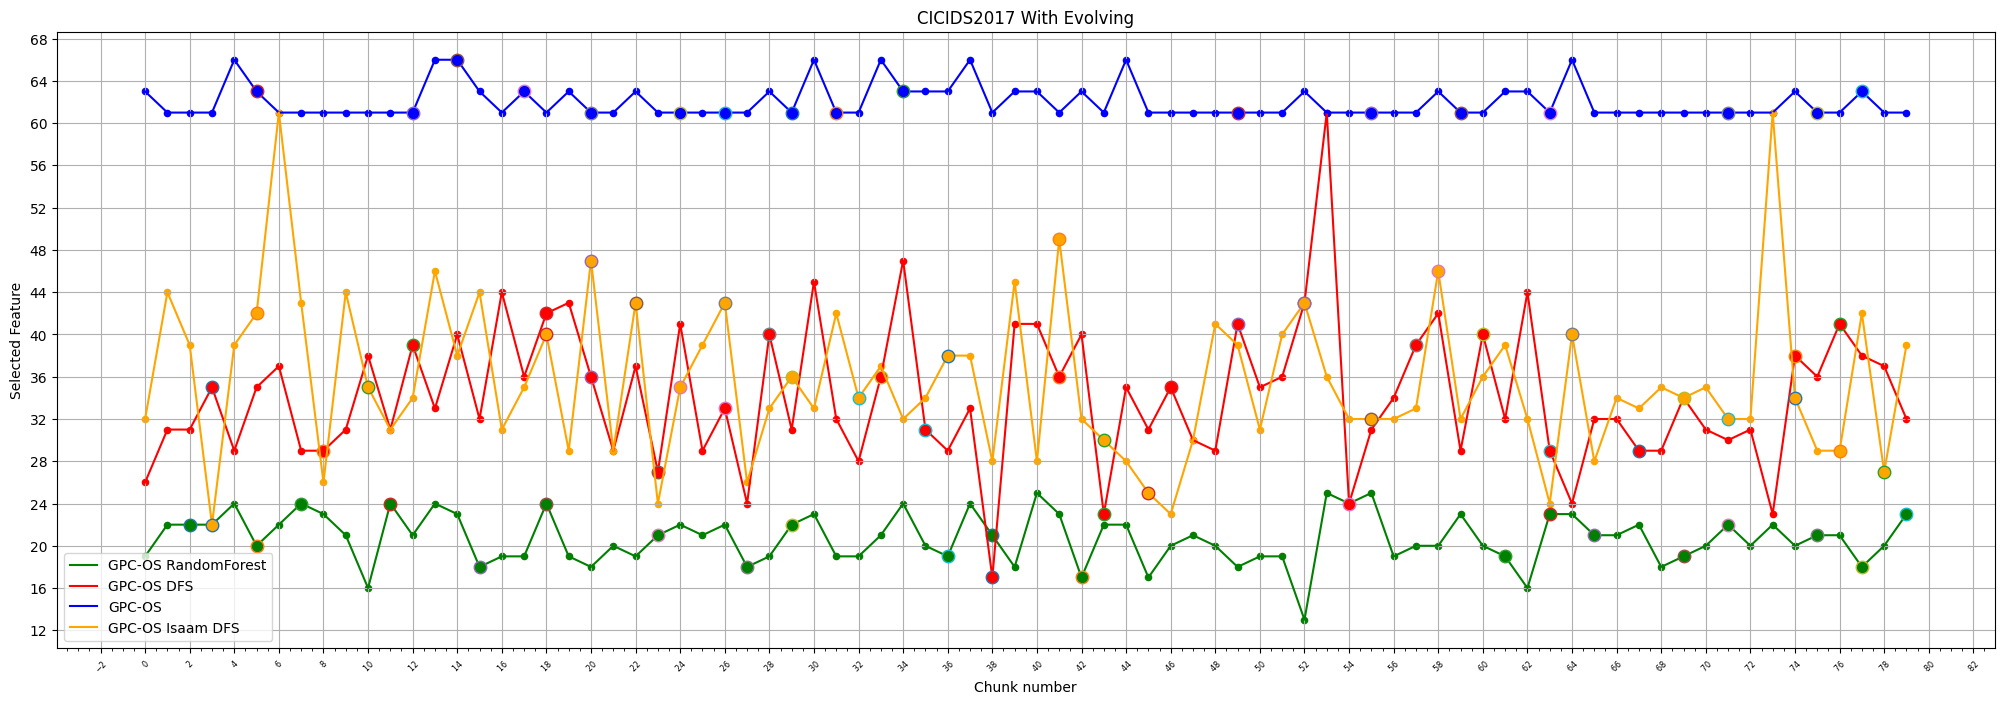

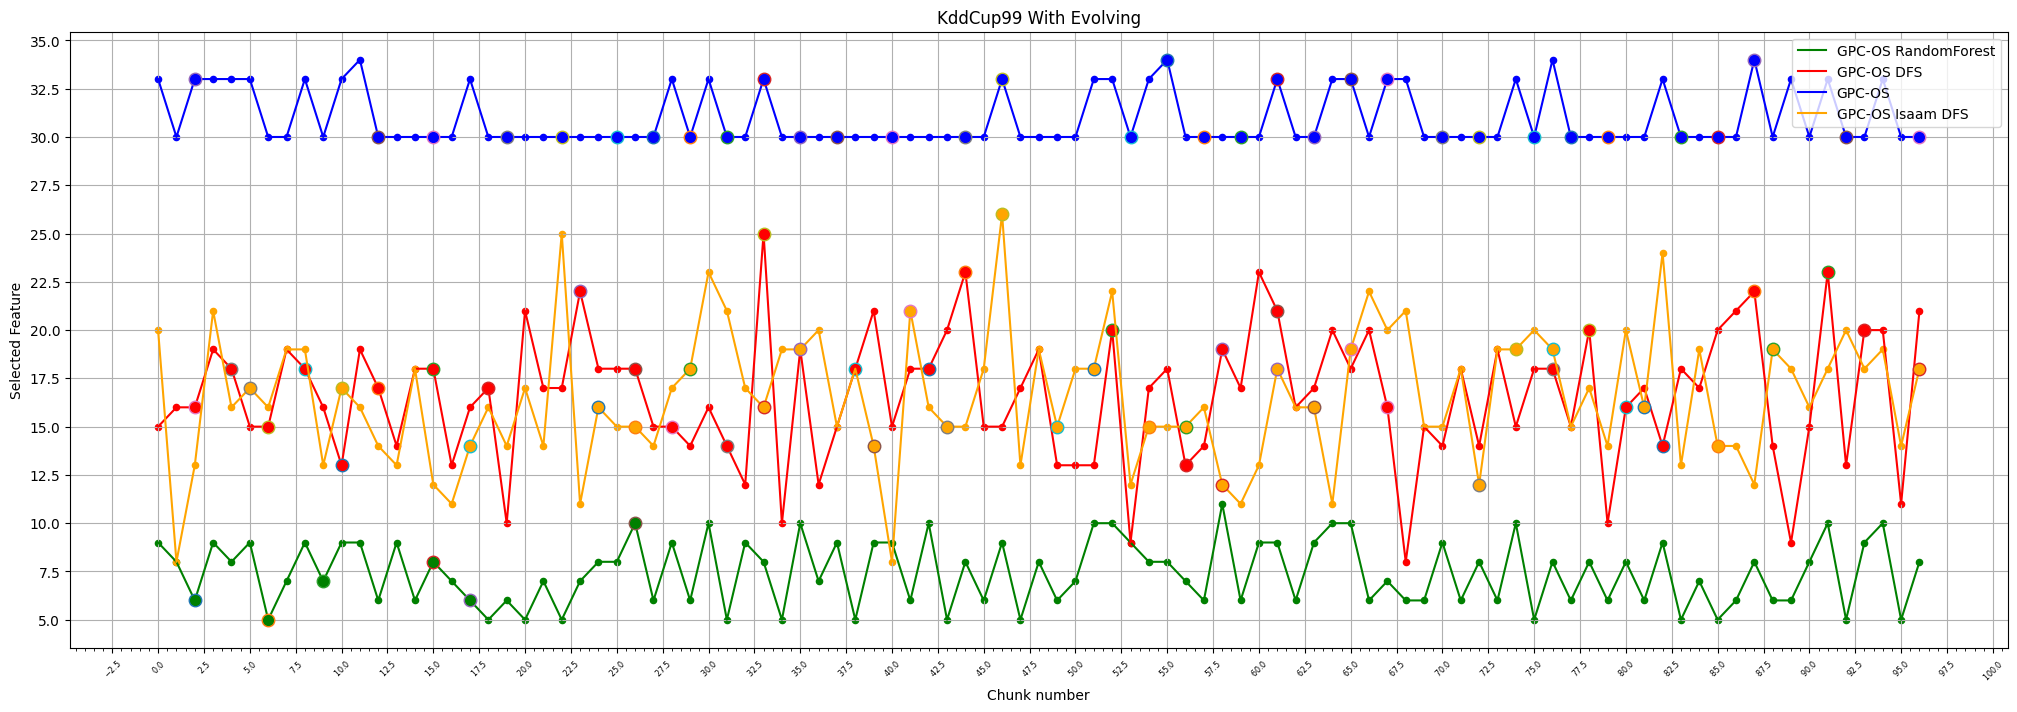

In [15]:
Finall_Results(folders=folders_evolving,Name="With Evolving")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


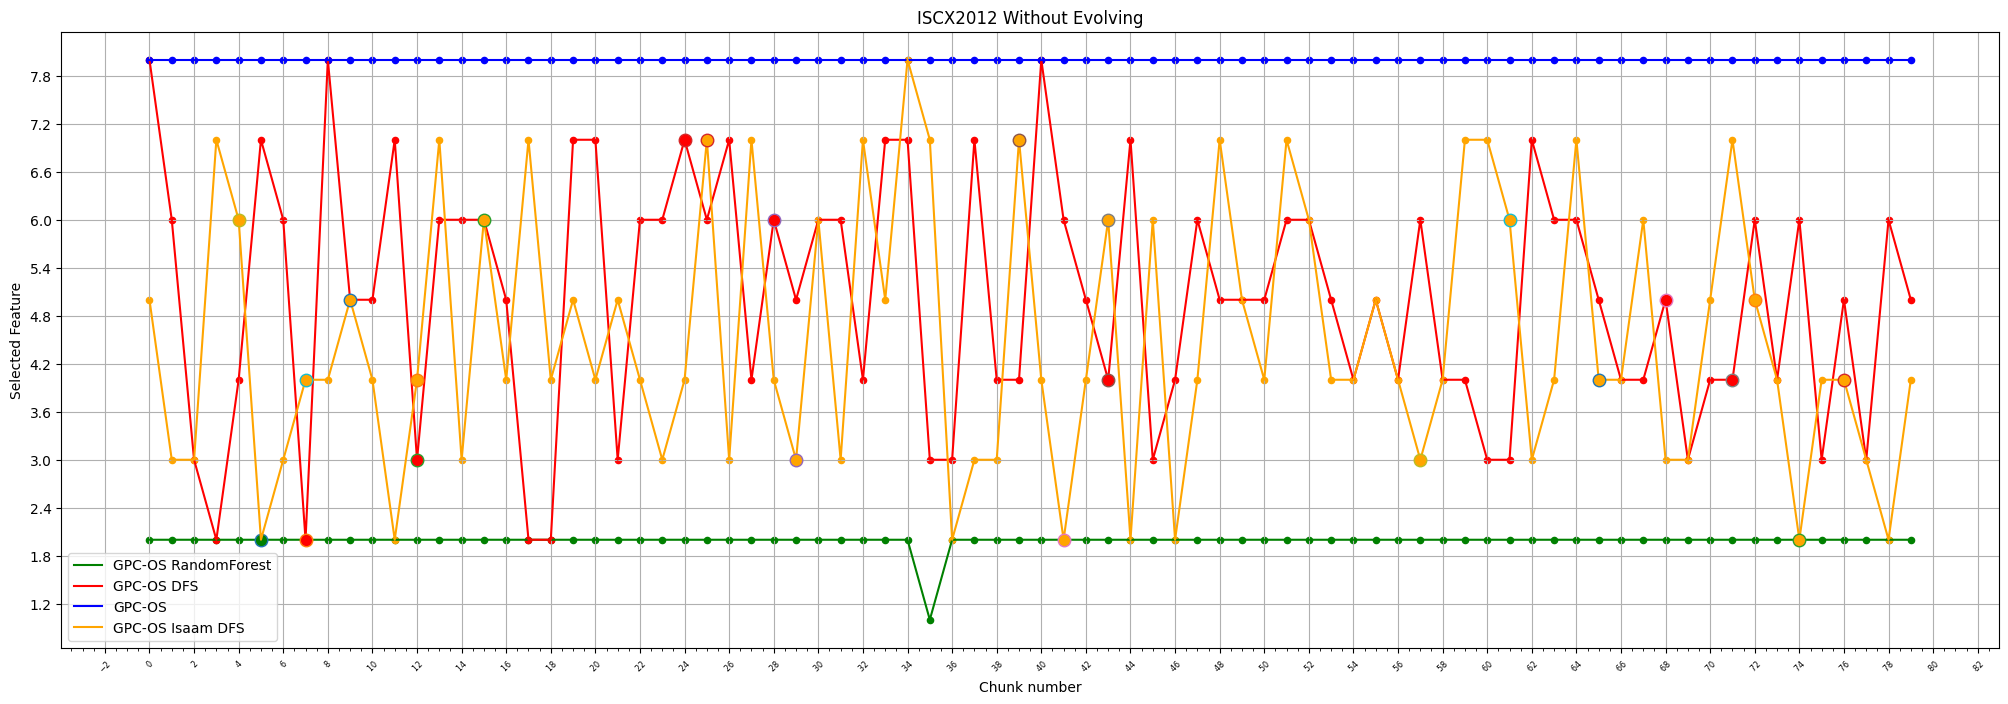

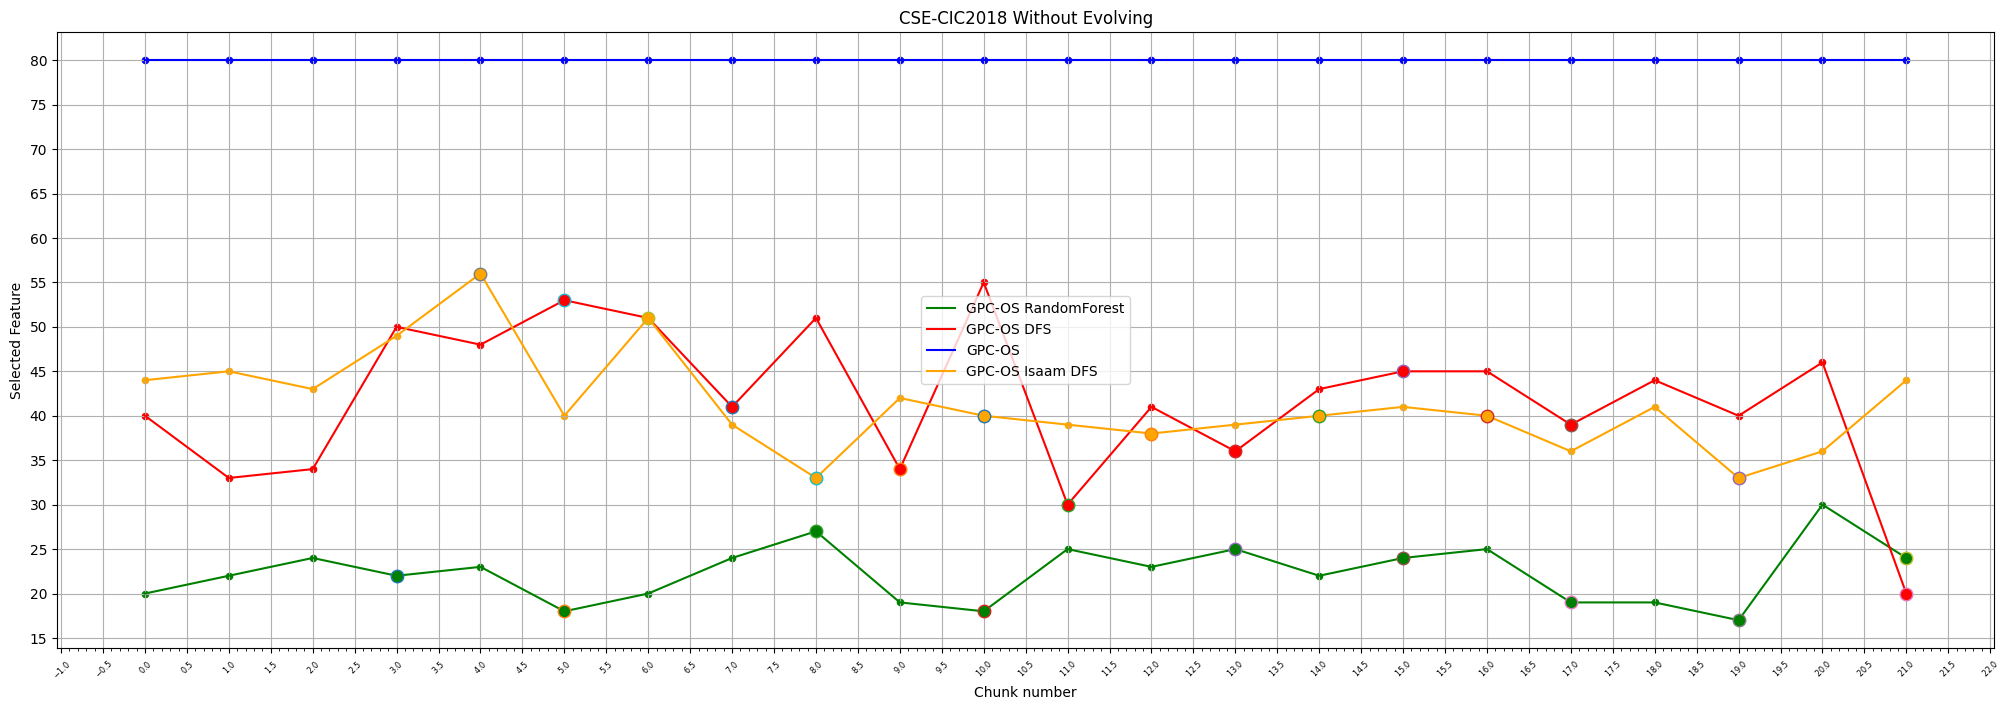

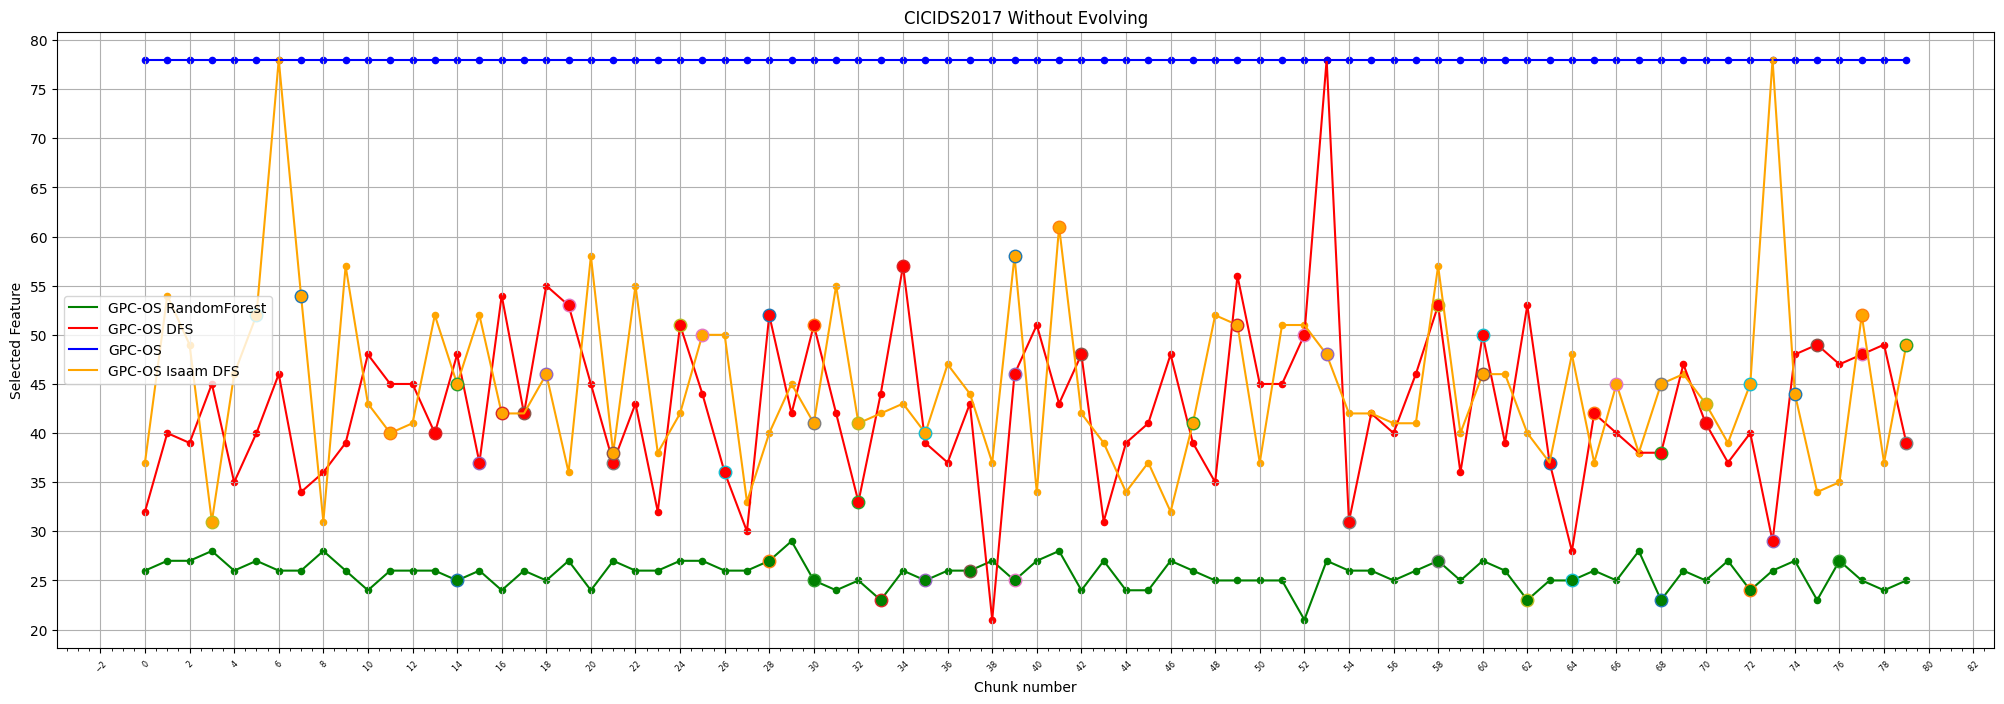

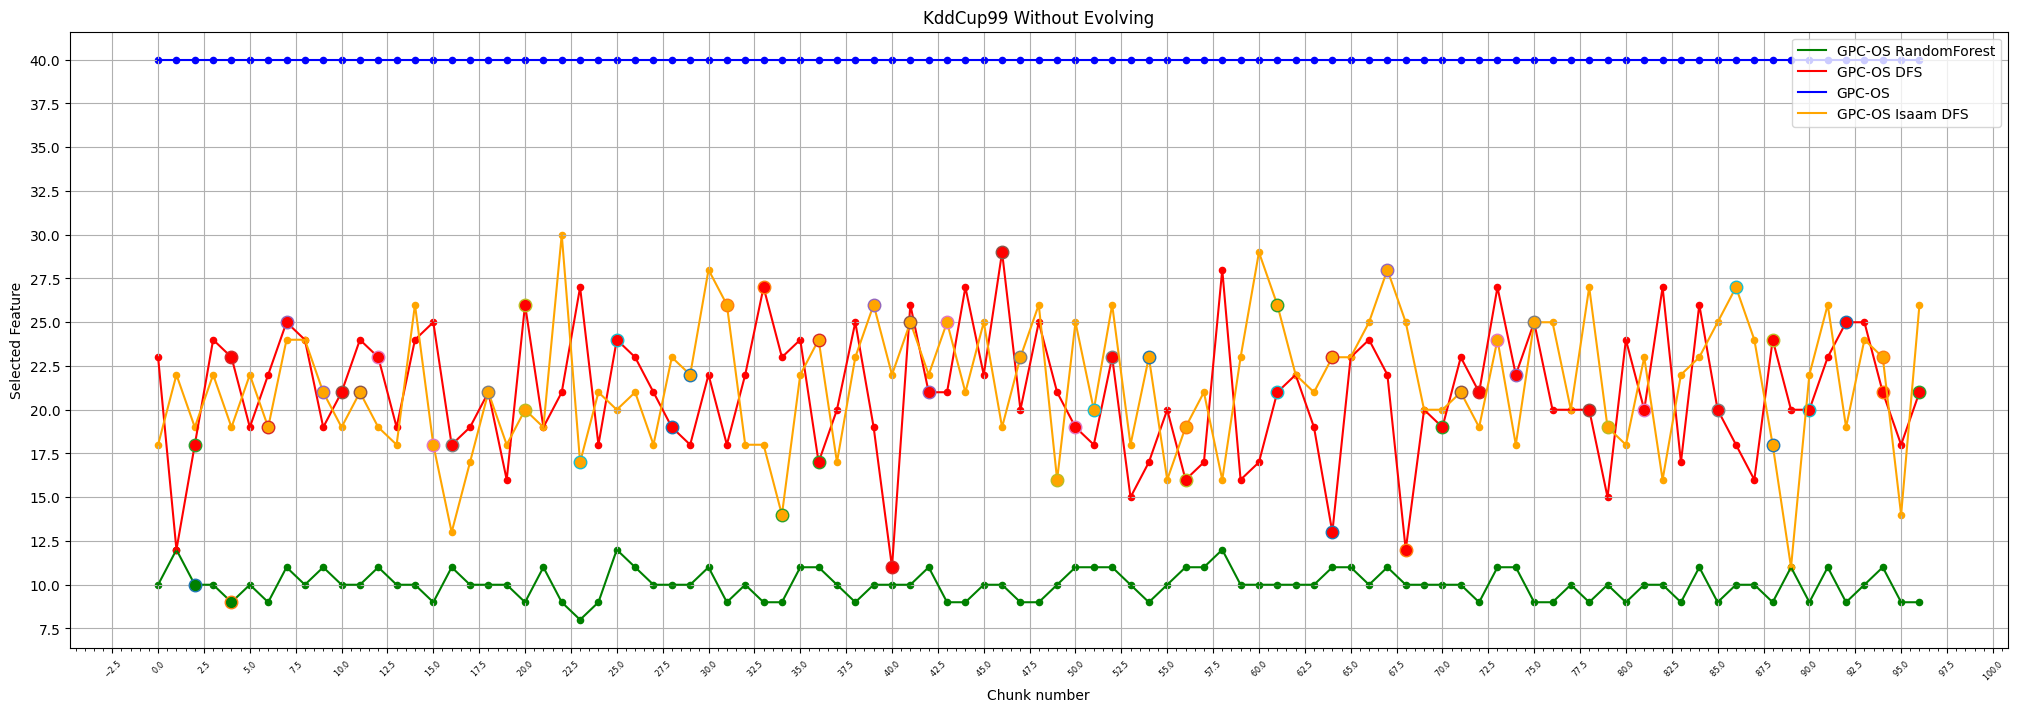

In [16]:
Finall_Results(folders=folders_without_evolving,Name="Without Evolving")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
